In [2]:
from ema_workbench.util import load_results

fn = r'./data/no policy 5000 runs.tar.gz'
results = load_results(fn)
experiments, outcomes = results

vensim dll not found, vensim functionality not available


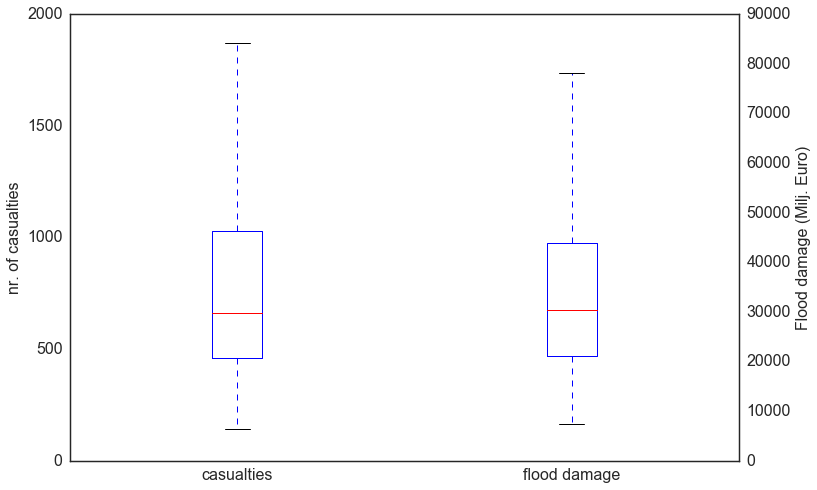

In [5]:

with sns.axes_style('white'):
    oois = outcomes.keys()
    oois.pop(oois.index('Costs'))
    data = []

    for ooi in oois:
        value = outcomes[ooi]
        if len(value.shape)>1:
            value = np.sum(value, axis=1)
        value = value/np.max(value)
        data.append(value)

    fig = plt.figure()

    casualties = np.sum(outcomes['Number of casualties'],axis=1)
    ax_casualties = fig.add_subplot(111)
    ax_casualties.boxplot([casualties,[]])
    ax_casualties.set_ylabel('nr. of casualties')

    damages = np.sum(outcomes['Flood damage (Milj. Euro)'],axis=1)
    ax_damage = ax_casualties.twinx()
    ax_damage.boxplot([[],damages])
    ax_damage.set_ylabel('Flood damage (Milj. Euro)')

    ax_casualties.set_xticklabels(['casualties', 'flood damage'])
    ax_casualties.set_ylim(ymin=0)

change_fontsize(fig, 16)
save_fig(fig, './figs/', 5)

plt.show()

In [6]:
for ooi in oois:
    value = outcomes[ooi]
    value = np.sum(value, axis=1)
    print ooi, np.mean(value), np.std(value)

Number of casualties 756.9814067 388.78367684
Flood damage (Milj. Euro) 34608.543 17107.6871672


The above figure shows boxplots for both casualties and flood damage. As can be seen, without any policy, there are quite a large number of casualties as well as a substantial amount of damages. The next question is then, under which combination of debelopments do we observe a high amount of casualties and or flood damage? To simplify this question, first let's take a quick look at the correlation between casuatlies and flood damage. If this correlation is high, we might be able to use only one or the other in classifying our experiments. 

In [7]:
print np.corrcoef(casualties, damages)
print

# returns the correlation and the p value
print sp.stats.stats.pearsonr(casualties, damages)

[[ 1.          0.80732637]
 [ 0.80732637  1.        ]]

(0.80732637205751356, 0.0)


There is a statistically significant correlation between the number of casualties and the amount of damage, we can thus simplify the scneario discovery by using either the number of casualties or the amount of flood damage in the classify function. 

## First iteration scenario discovery

We can now perform scenario discovery. 

$
f(x) = 
    \begin{cases}
        1 & \text{if } x > 50.000 \\
        0 & \text{otherwise}
    \end{cases}
$$
$

where $x$ is the amount of flood damage


In [8]:
from ema_workbench.analysis import prim
from ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

def classify(data):
    ooi = 'Flood damage (Milj. Euro)'
    outcome = np.sum(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>50000] = 1
    return classes

prim_obj = prim.setup_prim(results, classify, threshold=0.75)
box_1 = prim_obj.find_box()



[INFO] 5000 points remaining, containing 972 cases of interest
[INFO] mean: 0.98730964467, mass: 0.0788, coverage: 0.400205761317, density: 0.98730964467 restricted_dimensions: 3.0


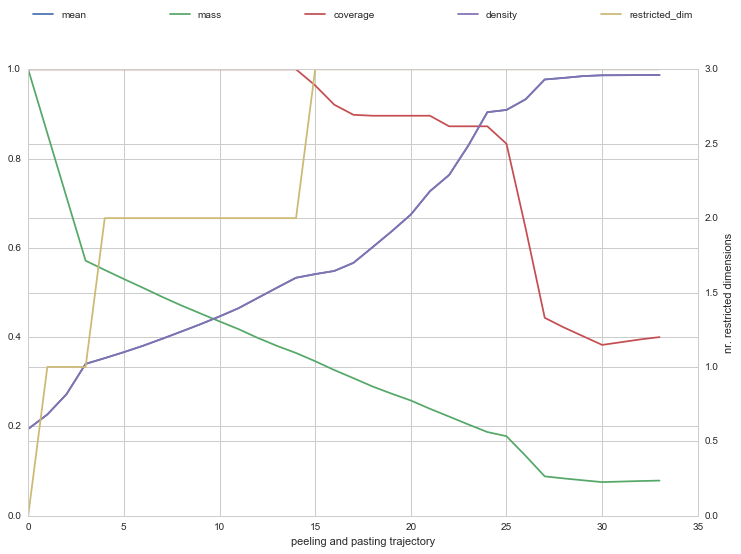

In [9]:
import mpld3
box_1.show_ppt()
plt.show()
box_1.show_tradeoff()
mpld3.display()

In [10]:
box_1.inspect(24)
box_1.select(24)


coverage    0.872428
density     0.904051
mass        0.187600
mean        0.904051
res dim     3.000000
Name: 24, dtype: float64

                                                               box 24  \
                                                                  min   
climate scenarios                                                  21   
land use scenarios  {urbanizationLargeSteady, urbanizationDeurbani...   
DamFunctTbl                                                -0.0917143   

                                                                       \
                                                                  max   
climate scenarios                                                  30   
land use scenarios  {urbanizationLargeSteady, urbanizationDeurbani...   
DamFunctTbl                                                 0.0999638   

                                   
                        qp values  
climate scenarios   6.158837e-284  
land use scenarios  1.427703e

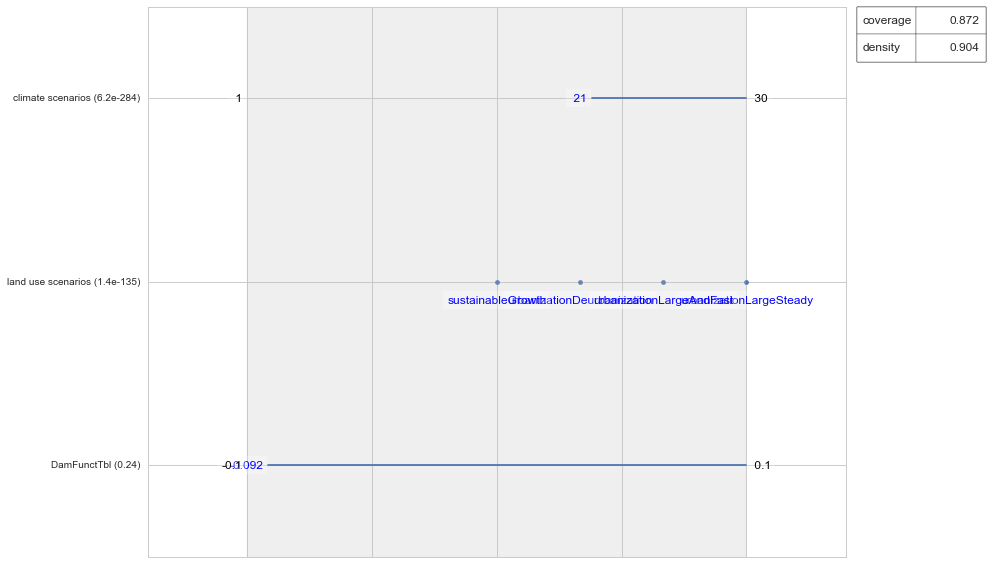

In [11]:
box_1.inspect(style='graph')
plt.show()

Using scenario discovery, we are able to find a single box that contains 87% of all the cases of interest, with a density of 90&. This box thus explains with high fidelity the conditions under which the most sever economic damages occur. This box is composes of climate scenarios 21-30, these are different realizations of the most sever climate change scenario, in combination with a growing population as represented by the selected land use scenarios. The parameter `DamFuncTbl` is a model specific uncertainy related to the relationship between water levels and econmic damages. Given that this paramater is not singificant as indicated by the quasi-p value, we drop it from the box for interpretation reasons. 

In [12]:
box_1.drop_restriction('DamFunctTbl')
box_1.inspect()

coverage    0.907407
density     0.896341
mass        0.196800
mean        0.896341
res dim     2.000000
Name: 34, dtype: float64

                                                               box 34  \
                                                                  min   
climate scenarios                                                  21   
land use scenarios  {urbanizationLargeSteady, urbanizationDeurbani...   

                                                                       \
                                                                  max   
climate scenarios                                                  30   
land use scenarios  {urbanizationLargeSteady, urbanizationDeurbani...   

                                   
                        qp values  
climate scenarios   3.639663e-291  
land use scenarios  6.343350e-137  



This changes coverage and density slightly. Coverage increases from 87% to 91%, while density remains stable. Droping this parameter from the box limits thus improved the overall quality of the box. 

So, what kind of vulnerability does this box represent? In essence, under extreme climate change and growing population, you get a lot of problems. This is hardly a surprising result. It also indicates that the system in its current state is already in need of additional actions.

# second iteration, 5 policies

There is a variety of ways in which the identified vulnerability can be handeld. These options include heightening the dikes, room for the river, strenghtening the dikes by making them wider (so called climate dikes), upstream collaboration, and earlier evacuation. These five policy options are not identical in their effect. For example, earlier evacuation will not change the damages but only reduce casualties. We ran 5000 experiments for each of these policy options. For heightening the dikes and room for the river, we start with a medium sized option. That is, we give some space to the river, or modestly increase the height of the dikes. In light of the following analysis, we might explore whether a smaller or larger scale version of this policy option is in order. Because we now include policy options, we added costs as a third indicator. 

In [13]:
from ema_workbench.util import load_results

# load the data and split it by policy
# we end up with a dict with policy as key
# and the associated experiments and outcomes
# as value
results_dict = {}

fn  = r'./data/6 policies 5000 runs.tar.gz'
experiments, outcomes = load_results(fn)

policies = list(set(experiments['policy']))

for policy in policies:
    logical = experiments['policy']==policy
    
    temp_exp = experiments[logical]
    temp_outcomes = {}
    for key, value in outcomes.iteritems():
        temp_outcomes[key] = value[logical]
    results_dict[policy] = (temp_exp, temp_outcomes)


[INFO] results loaded succesfully from ./data/6 policies 5000 runs.tar.gz


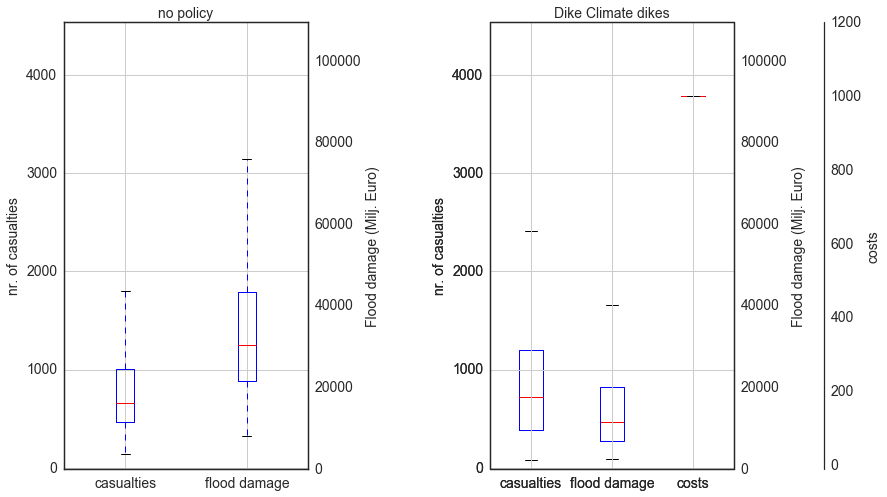

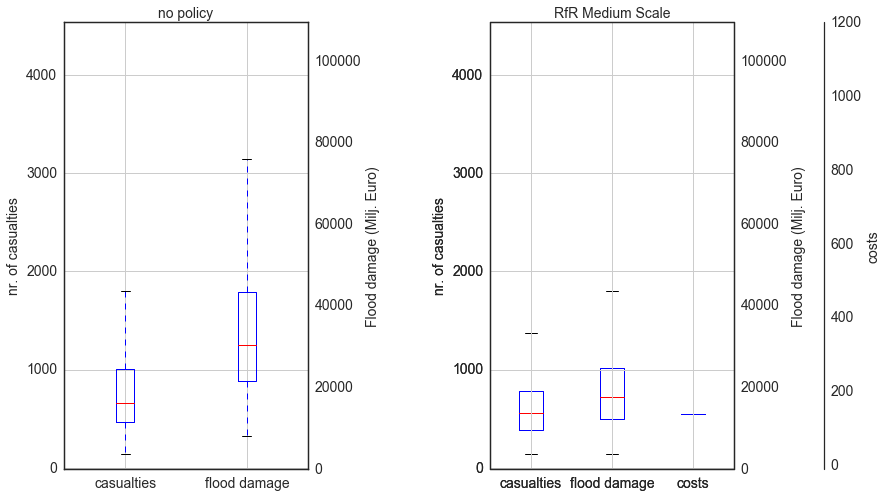

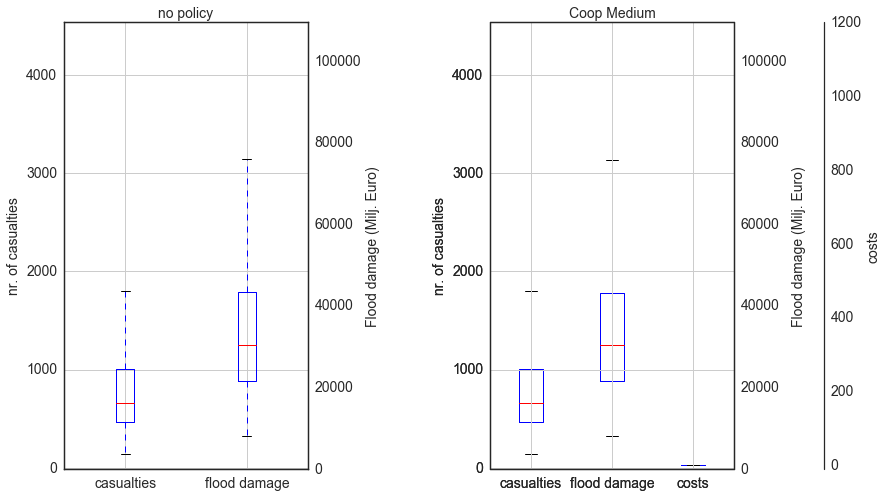

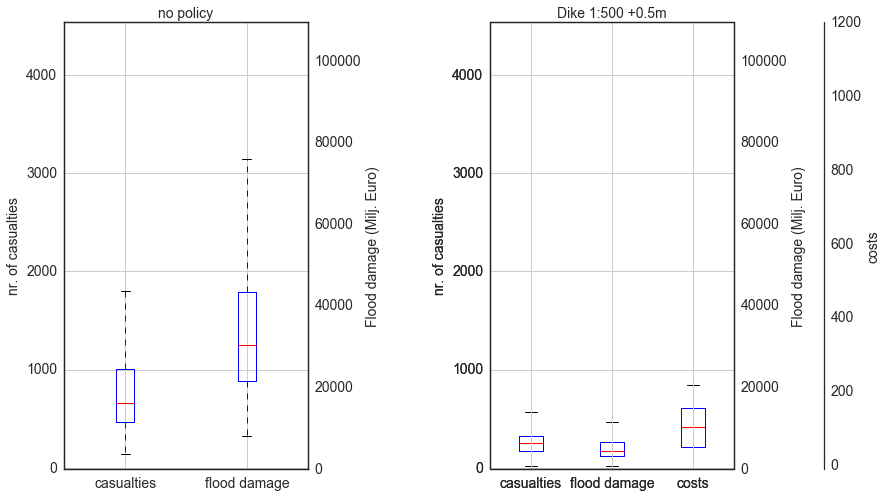

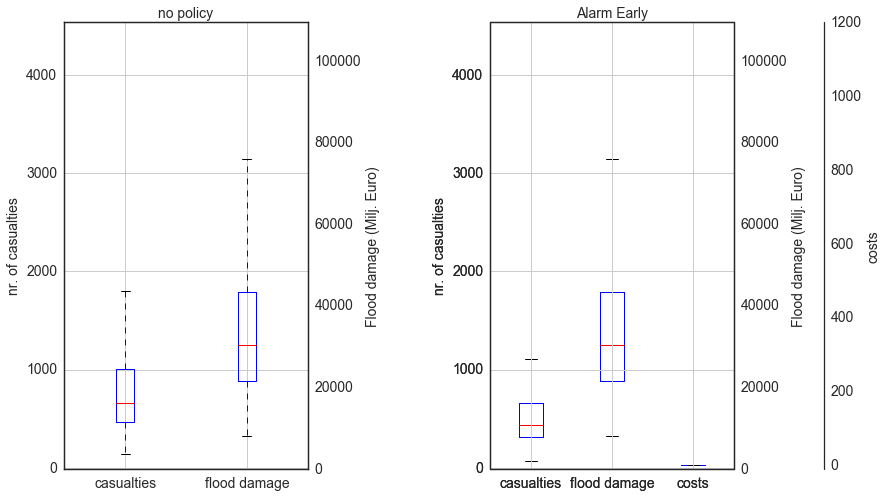

In [14]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

policies = list(set(experiments['policy']))
policies.remove('no policy')

#determine maxima across all policies
costs = outcomes['Costs']
costs[costs==1e31] = 0
costs = np.sum(costs, axis=1)
max_costs = np.max(costs)

casualties = outcomes['Number of casualties']
casualties[casualties==1e31] = 0
casualties = np.sum(casualties, axis=1)
max_casualties = np.max(casualties)

damages = outcomes['Flood damage (Milj. Euro)']
damages[damages==1e31] = 0
damages = np.sum(damages, axis=1)
max_damages = np.max(damages)

def do_boxplot(results_dict, policy, compare_with='no policy'):
    fig = plt.figure()
    
    # no policy
    outcomes = results_dict[compare_with][1]
    casualties1 = np.sum(outcomes['Number of casualties'],axis=1)
    ax_casualties1 = fig.add_subplot(121)
    ax_casualties1.boxplot([casualties1,[]])
    ax_casualties1.set_ylabel('nr. of casualties')

    damages1 = np.sum(outcomes['Flood damage (Milj. Euro)'],axis=1)
    ax_damage1 = ax_casualties1.twinx()
    ax_damage1.boxplot([[],damages1])
    ax_damage1.set_ylabel('Flood damage (Milj. Euro)')

    ax_casualties1.set_xticklabels(['casualties', 'flood damage'])
    ax_casualties1.set_ylim(ymin=0)
    ax_casualties1.set_title(compare_with)
    ax_casualties1.grid(True)
        
    # policy
    outcomes = results_dict[policy][1]
    casualties2 = np.sum(outcomes['Number of casualties'],axis=1)
    ax_casualties2 = host = host_subplot(122, axes_class=AA.Axes)
    ax_casualties2.boxplot([casualties2,[],[]])
    ax_casualties2.set_ylabel('nr. of casualties')

    damages2 = np.sum(outcomes['Flood damage (Milj. Euro)'],axis=1)
    ax_damage2 = ax_casualties2.twinx()
    ax_damage2.boxplot([[],damages2,[]])
    ax_damage2.set_ylabel('Flood damage (Milj. Euro)')
    
    costs = np.sum(outcomes['Costs'],axis=1)
    ax_costs = ax_casualties2.twinx()
    offset = 90
    
    new_fixed_axis = ax_costs.get_grid_helper().new_fixed_axis
    ax_costs.axis["right"] = new_fixed_axis(loc="right",
                                        axes=ax_costs,
                                        offset=(offset, 0))

    ax_costs.axis["right"].toggle(all=True)
    ax_costs.boxplot([[],[], costs])
    ax_costs.set_ylabel('costs')
    
    ax_casualties2.set_xticklabels(['casualties', 'flood damage','costs'])
    ax_casualties2.set_ylim(ymin=0)
    ax_casualties2.set_title(policy)
    ax_casualties2.grid(True)
    
    # the xaxis for must be set to the same limits
    ax_casualties1.set_ylim(ymin=-10, ymax=1.2*max_casualties)
    ax_casualties2.set_ylim(ymin=-10, ymax=1.2*max_casualties)
    
    ax_damage1.set_ylim(ymin=-10, ymax=1.2*max_damages)
    ax_damage2.set_ylim(ymin=-10, ymax=1.2*max_damages)
    
    ax_costs.set_ylim(ymin=-10, ymax=1.2*max_costs)

    
    plt.subplots_adjust(wspace = .75)
    
    return fig

for policy in policies:
    with sns.axes_style('white'):
        fig = do_boxplot(results_dict, policy)
        change_fontsize(fig)
        
    
    plt.show()

The above figures show a side by side comparison of each of the five policy options and doing nothing. As can be seen, raising the dikes is by far the most effective option. It substantially reduces both casualties and damages. A minor downside is the uncertainty associated with the exact costs. This is due to the fact that the dike height is based on a design discharge, which is continuously updated during the runtime in light of the latest discharge. This is standard practice in the Netherlands. The other policy options are substantially less effective. Climate dikes are broad enought to avoid breaching, but can still be overtopped. They improve the situation slightly, but are not very effective because the dikes are still too low. Medium scale room for the river results in a minor reduction of casualties and flood damage. Upstream collaboration is not effective, because the resulting maximum discharge is still heigher than the dikes can handle. Earlier alarm reduces casualities substantially, but does not affect the damages. 





[INFO] results loaded succesfully from ./data/6 policies 5000 runs.tar.gz


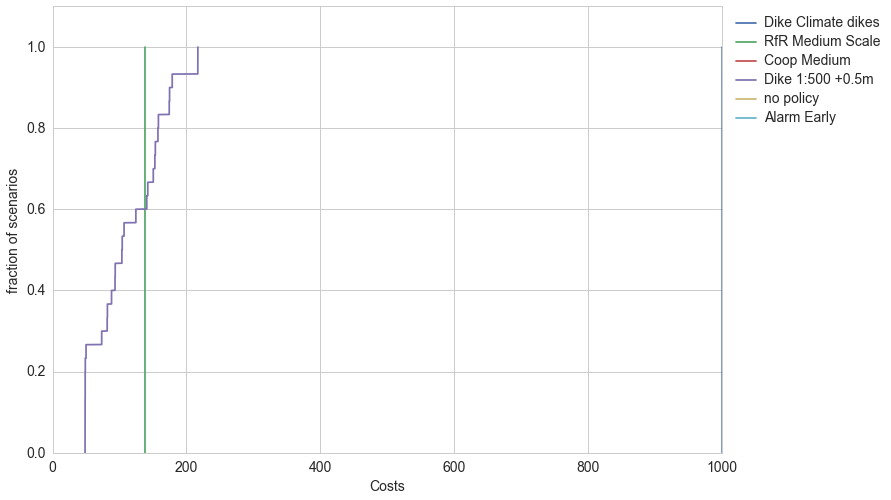

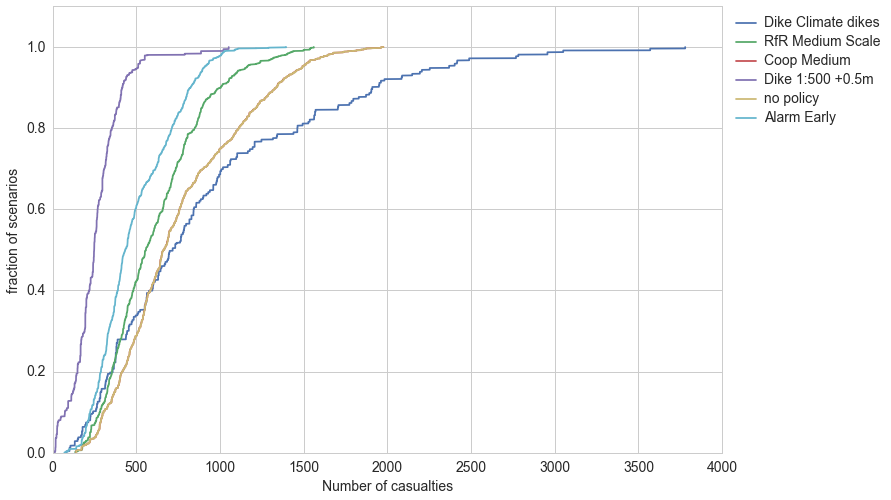

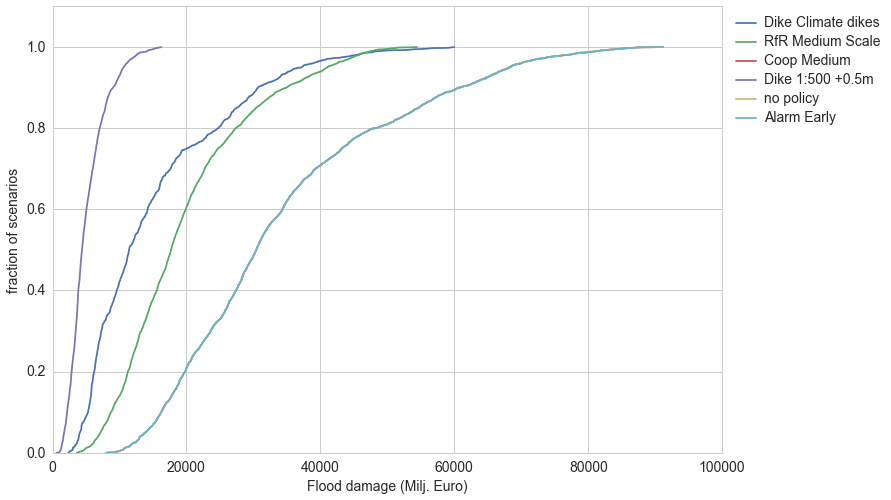

In [15]:
fn  = r'./data/6 policies 5000 runs.tar.gz'
experiments, outcomes = load_results(fn)

policies = list(set(experiments['policy']))

temp_outcomes = {}
for key, value in outcomes.items():
    value = np.sum(value, axis=1)
    temp_outcomes[key] = value
outcomes = temp_outcomes
    

for ooi in outcomes.keys():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_ylabel('fraction of scenarios')
    
    for policy in policies:
        logical = experiments['policy']==policy
        
        data = outcomes[ooi][logical]
        x = np.sort(data)
        y = np.arange(len(x))/float(len(x))
        
        ax.plot(x, y, label=policy)
        ax.set_xlabel(ooi)
    ax.set_ylim(ymax=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.25,1))
    
    change_fontsize(fig)
    
plt.show()
    

[INFO] results loaded succesfully from ./data/6 policies 5000 runs.tar.gz


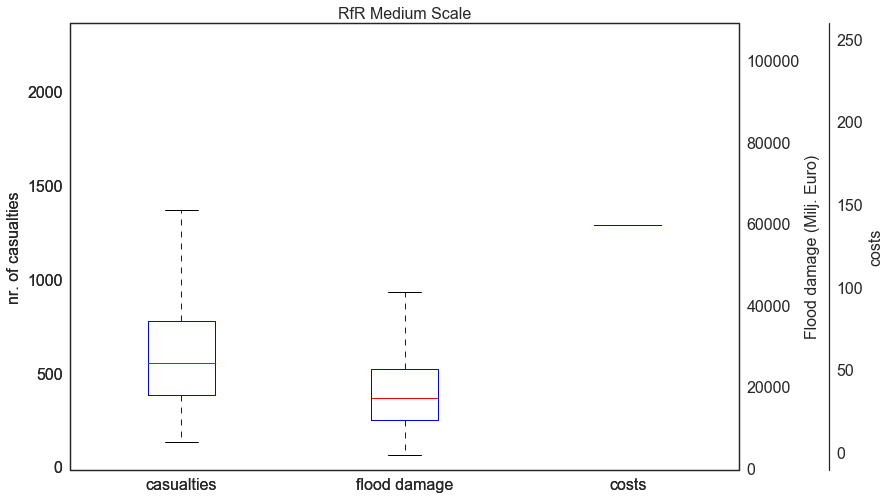

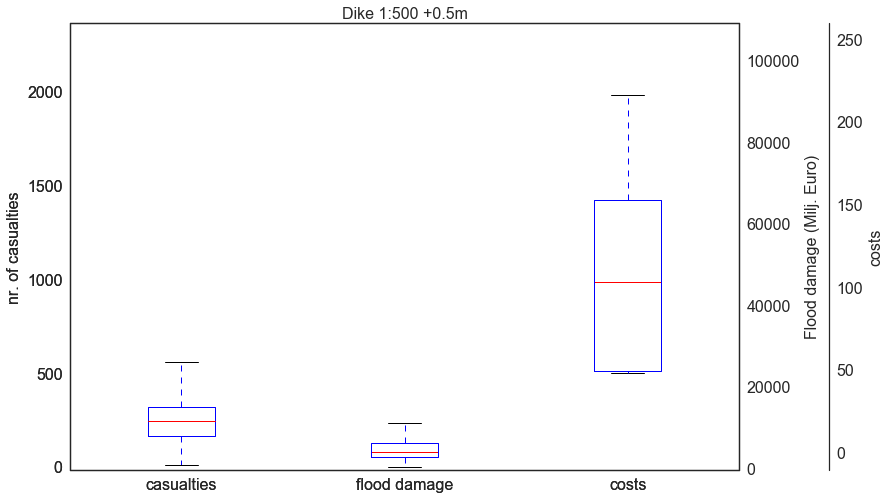

In [18]:
fn  = r'./data/6 policies 5000 runs.tar.gz'
experiments, outcomes = load_results(fn)

outcomes = {key:np.sum(value, axis=1) for key, value in
            outcomes.items()}


policies = ['RfR Medium Scale', 'Dike 1:500 +0.5m']

logical = np.zeros(experiments.shape, dtype=np.bool)
for policy in policies:
    logical[experiments['policy']==policy] = True
logical[experiments['policy']=='no policy'] = True

max_casualties = np.max(outcomes['Number of casualties'][logical])
max_damages = np.max(outcomes['Flood damage (Milj. Euro)'][logical])
max_costs = np.max(outcomes['Costs'][logical])

    
with sns.axes_style('white'):
    for i, policy in enumerate(policies):
        logical = experiments['policy']==policy

        # policy
        casualties = outcomes['Number of casualties'][logical]
        ax_casualties = host = host_subplot(111, axes_class=AA.Axes)
        ax_casualties.boxplot([casualties,[],[]])
        ax_casualties.set_ylabel('nr. of casualties')

        damages = outcomes['Flood damage (Milj. Euro)'][logical]
        ax_damage = ax_casualties.twinx()
        ax_damage.boxplot([[],damages,[]])
        ax_damage.set_ylabel('Flood damage (Milj. Euro)')

        costs = outcomes['Costs'][logical]
        ax_costs = ax_casualties.twinx()
        offset = 90

        new_fixed_axis = ax_costs.get_grid_helper().new_fixed_axis
        ax_costs.axis["right"] = new_fixed_axis(loc="right",
                                            axes=ax_costs,
                                            offset=(offset, 0))

        ax_costs.axis["right"].toggle(all=True)
        ax_costs.boxplot([[],[], costs])
        ax_costs.set_ylabel('costs')

        ax_casualties.set_xticklabels(['casualties', 'flood damage','costs'])
        ax_casualties.set_ylim(ymin=0)
        ax_casualties.set_title(policy)

        # the xaxis for must be set to the same limits
        ax_casualties.set_ylim(ymin=-10, ymax=1.2*max_casualties)

        ax_damage.set_ylim(ymin=-10, ymax=1.2*max_damages)

        ax_costs.set_ylim(ymin=-10, ymax=1.2*max_costs)
        plt.subplots_adjust(wspace = .75)

        fig = plt.gcf()
        change_fontsize(fig, 16)
        save_fig(fig, './figs/', '6{}'.format(chr(i + ord('a'))))


        plt.show()


## Second iteration scenario discovery

Given that raising the dikes is the most effective solution. we focuss on this option in the next iteration of scenario discovery. The aim is to understand what the remaining vulnerabilities of this policy are.

In [19]:
from ema_workbench.util import load_results
fn  = r'./data/6 policies 5000 runs.tar.gz'
experiments, outcomes = load_results(fn)

policies = ['RfR Medium Scale', 'Dike 1:500 +0.5m']
logical = np.zeros(experiments.shape, dtype=np.bool)
for policy in policies:
    logical[experiments['policy']==policy]=True

outcomes = {key:np.sum(value, axis=1)[logical] for key, value in
            outcomes.items()}
experiments = experiments[logical]
results = (experiments, outcomes)


[INFO] results loaded succesfully from ./data/6 policies 5000 runs.tar.gz


In [20]:
casualties = outcomes['Number of casualties']
damages = outcomes['Flood damage (Milj. Euro)']

print np.corrcoef(casualties, damages)
print

# returns the correlation and the p value
print sp.stats.stats.pearsonr(casualties, damages)

[[ 1.          0.82273562]
 [ 0.82273562  1.        ]]

(0.82273561931990868, 0.0)


There still exists a statistically significant correlation, 

### scenario discovery for damages

We can now perform scenario discovery. 

$
f(x) = 
    \begin{cases}
        1 & \text{if } x > 7.500 \\
        0 & \text{otherwise}
    \end{cases}
$$
$

where $x$ is the amount of flood damage

In [22]:
from ema_workbench.analysis import prim
from ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

def classify(data):
    ooi = 'Flood damage (Milj. Euro)'
    outcome = outcomes[ooi]
    classes = np.zeros(outcome.shape[0])
    classes[outcome>10000] = 1
    return classes

results[0]['policy'] = 'na'

prim_obj = prim.setup_prim(results, classify, threshold=0.5, peel_alpha=0.01)
box_1 = prim_obj.find_box()

[INFO] 10000 points remaining, containing 4647 cases of interest
[INFO] mean: 0.663612565445, mass: 0.0764, coverage: 0.109102646869, density: 0.663612565445 restricted_dimensions: 7.0


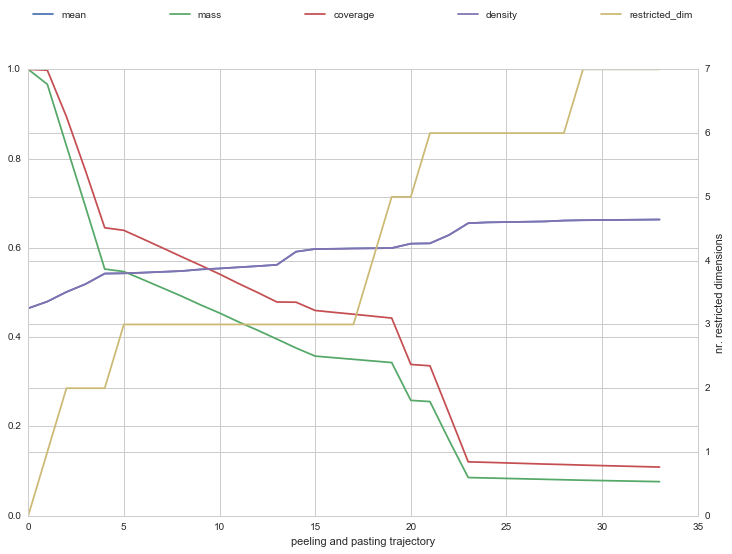

In [23]:
box_1.show_ppt()
plt.show()
box_1.show_tradeoff()
mpld3.display()

In [24]:
box_1.inspect(14)
box_1.inspect(20)

coverage    0.478373
density     0.591538
mass        0.375800
mean        0.591538
res dim     3.000000
Name: 14, dtype: float64

                                                               box 14  \
                                                                  min   
climate scenarios                                                  11   
land use scenarios  {urbanizationLargeSteady, urbanizationDeurbani...   
fragility dikes                                            -0.0999823   

                                                                       \
                                                                  max   
climate scenarios                                                  30   
land use scenarios  {urbanizationLargeSteady, urbanizationDeurbani...   
fragility dikes                                             0.0979795   

                                  
                       qp values  
climate scenarios   1.108469e-15  
land use scenarios  1.289178e-12

In [25]:
box_1.select(20)

# let's drop the insignificant restrictions
box_1.drop_restriction('fragility dikes')
box_1.drop_restriction('DamFunctTbl')
box_1.drop_restriction('ShipTbl3')

In [26]:
box_1.inspect()


coverage    0.354422
density     0.607749
mass        0.271000
mean        0.607749
res dim     2.000000
Name: 36, dtype: float64

                                                               box 36  \
                                                                  min   
climate scenarios                                                  12   
land use scenarios  {urbanizationLargeSteady, urbanizationLargeAnd...   

                                                                       \
                                                                  max   
climate scenarios                                                  30   
land use scenarios  {urbanizationLargeSteady, urbanizationLargeAnd...   

                                  
                       qp values  
climate scenarios   9.315272e-15  
land use scenarios  3.242482e-10  



In [27]:
box_2 = prim_obj.find_box()

[INFO] 7290 points remaining, containing 3000 cases of interest
[INFO] mean: 0.611969111969, mass: 0.0518, coverage: 0.0682160533678, density: 0.611969111969 restricted_dimensions: 8.0


In [28]:
box_2.show_tradeoff()
mpld3.display()

In [29]:
box_2.inspect(8)
box_2.inspect()

coverage    0.279966
density     0.482209
mass        0.269800
mean        0.482209
res dim     5.000000
Name: 8, dtype: float64

                                                                box 8  \
                                                                  min   
land use scenarios  {urbanizationLargeSteady, urbanizationDeurbani...   
climate scenarios                                                   2   
fragility dikes                                            -0.0999823   
ShipTbl2                                                   -0.0979855   
DamFunctTbl                                                -0.0981183   

                                                                       \
                                                                  max   
land use scenarios  {urbanizationLargeSteady, urbanizationDeurbani...   
climate scenarios                                                  30   
fragility dikes                                             0.0980

In [30]:
box_2.select(8)
box_2.drop_restriction('DamFunctTbl')
box_2.drop_restriction('ShipTbl2')
box_2.drop_restriction('fragility dikes')
box_2.inspect()

coverage    0.290725
density     0.479759
mass        0.281600
mean        0.479759
res dim     2.000000
Name: 38, dtype: float64

                                                               box 38  \
                                                                  min   
land use scenarios  {urbanizationLargeSteady, urbanizationDeurbani...   
climate scenarios                                                   2   

                                                                       \
                                                                  max   
land use scenarios  {urbanizationLargeSteady, urbanizationDeurbani...   
climate scenarios                                                  30   

                                  
                       qp values  
land use scenarios  5.919319e-08  
climate scenarios   2.125350e-03  





* dike raising 1:1000
* dike raising 1:500, combined with alarm early
* dike raising 1:500, combined with room for the river medium
* dike raising 1:500, combined with climate dikes

# third iteration, 5 policies


[INFO] results loaded succesfully from ./data/third iteration 7 policies  5000 runs.tar.gz


['Dike 1:500 +0.5m, Dike Climate dikes', 'Dike 1:500 +0.5m, RfR Large Scale', 'Dike 1:500 +0.5m, RfR Medium Scale', 'Dike 1:500 +0.5m', 'Dike 1:500 +0.5m, Alarm Early', 'no policy', 'Dike 1:1000']


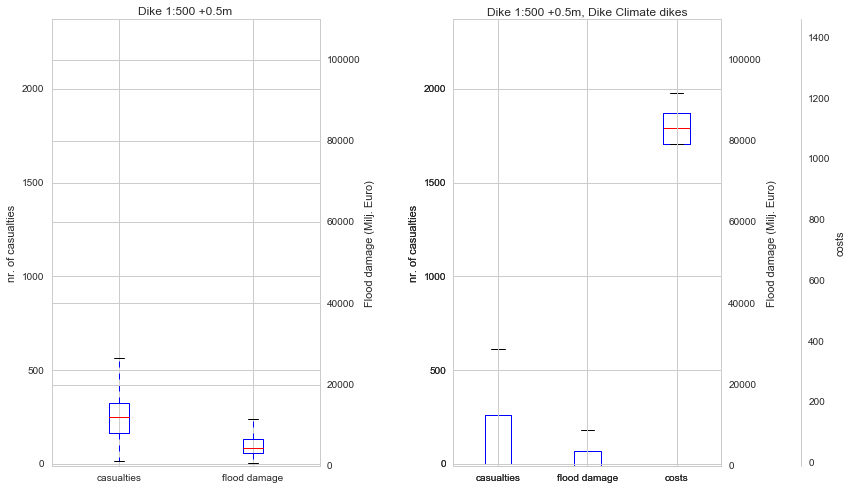

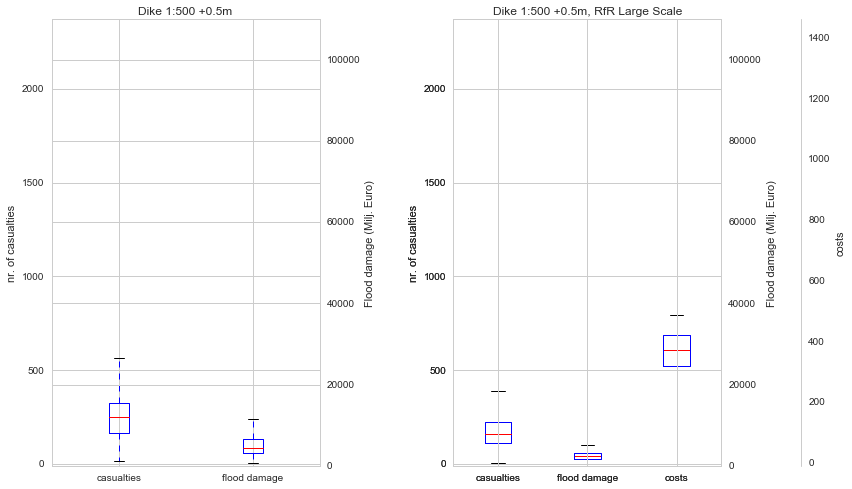

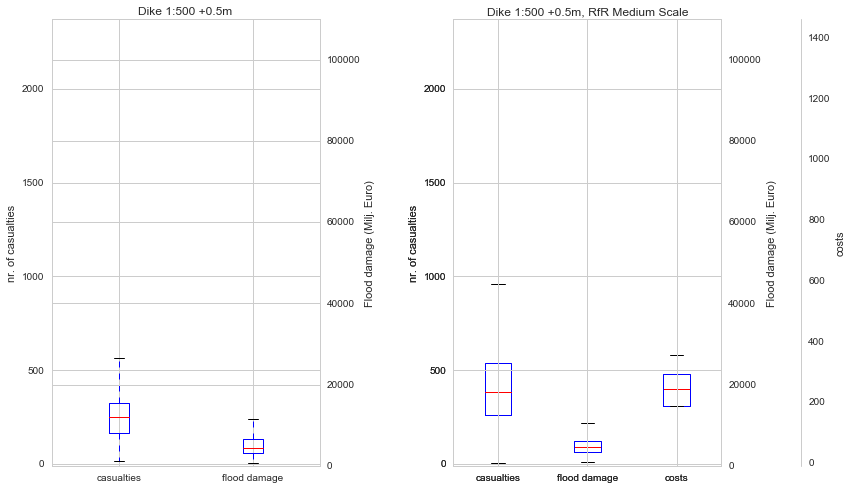

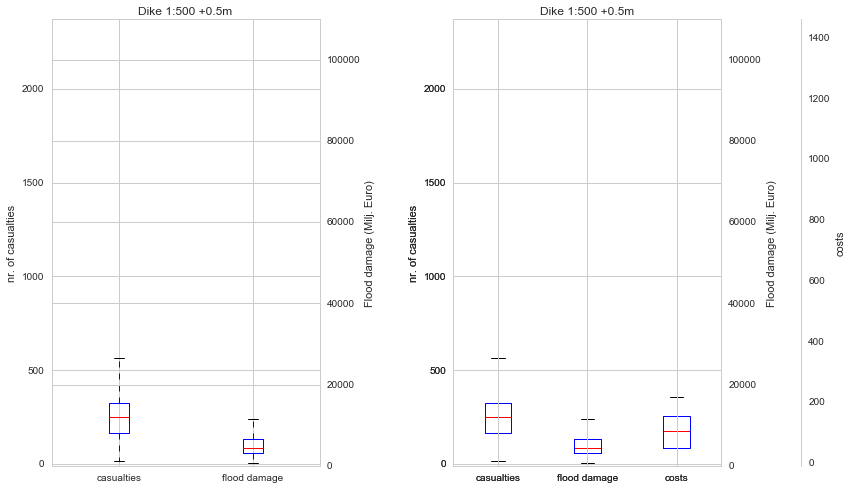

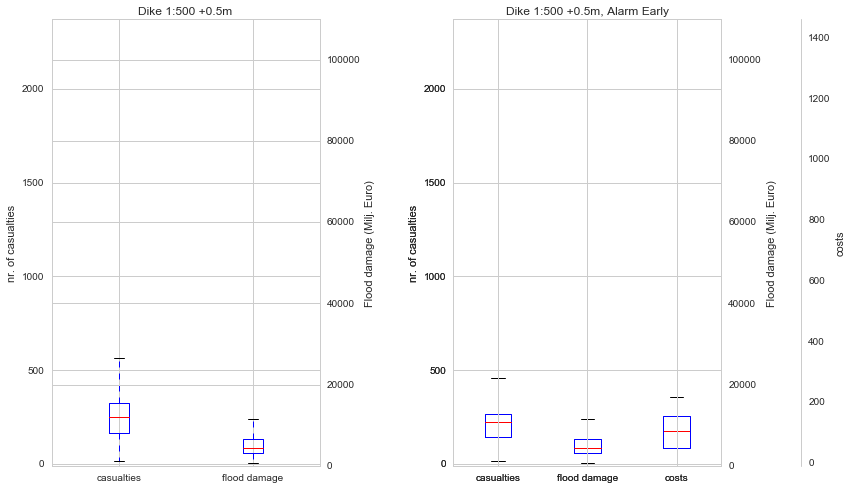

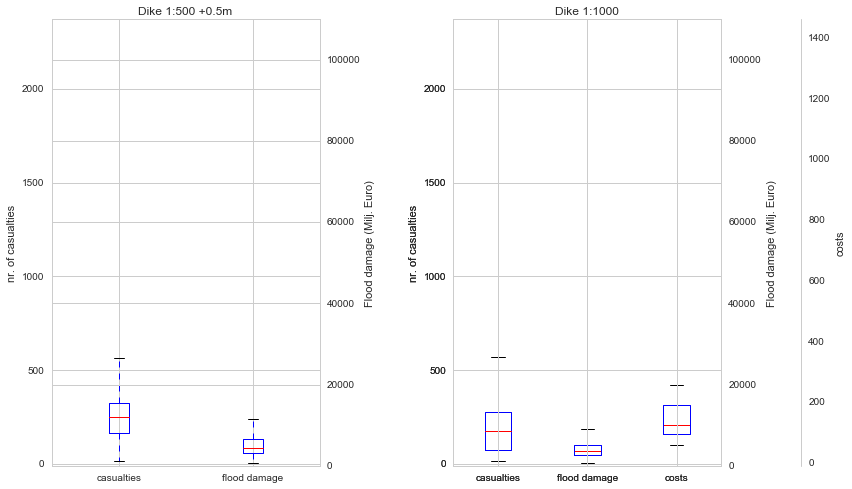

In [31]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from ema_workbench.util import load_results

def do_boxplot(results_dict, policy, compare_with='no policy'):
    fig = plt.figure()
    
    # no policy
    outcomes = results_dict[compare_with][1]
    casualties1 = outcomes['Number of casualties']
    ax_casualties1 = fig.add_subplot(121)
    ax_casualties1.boxplot([casualties1,[]])
    ax_casualties1.set_ylabel('nr. of casualties')

    damages1 = outcomes['Flood damage (Milj. Euro)']
    ax_damage1 = ax_casualties1.twinx()
    ax_damage1.boxplot([[],damages1])
    ax_damage1.set_ylabel('Flood damage (Milj. Euro)')

    ax_casualties1.set_xticklabels(['casualties', 'flood damage'])
    ax_casualties1.set_ylim(ymin=0)
    ax_casualties1.set_title(compare_with)
    ax_casualties1.grid(True)
        
    # policy
    outcomes = results_dict[policy][1]
    casualties2 = outcomes['Number of casualties']
    ax_casualties2 = host = host_subplot(122, axes_class=AA.Axes)
    ax_casualties2.boxplot([casualties2,[],[]])
    ax_casualties2.set_ylabel('nr. of casualties')

    damages2 = outcomes['Flood damage (Milj. Euro)']
    ax_damage2 = ax_casualties2.twinx()
    ax_damage2.boxplot([[],damages2,[]])
    ax_damage2.set_ylabel('Flood damage (Milj. Euro)')

    
    costs = outcomes['Costs']
    ax_costs = ax_casualties2.twinx()
    offset = 80
    
    new_fixed_axis = ax_costs.get_grid_helper().new_fixed_axis
    ax_costs.axis["right"] = new_fixed_axis(loc="right",
                                        axes=ax_costs,
                                        offset=(offset, 0))

    ax_costs.axis["right"].toggle(all=True)
    ax_costs.boxplot([[],[], costs])
    ax_costs.set_ylabel('costs')
    
    ax_casualties2.set_xticklabels(['casualties', 'flood damage','costs'])
    ax_casualties2.set_ylim(ymin=0)
    ax_casualties2.set_title(policy)
    ax_casualties2.grid(True)
    
    # the xaxis for must be set to the same limits
    ax_casualties1.set_ylim(ymin=-10, ymax=1.2*max_casualties)
    ax_casualties2.set_ylim(ymin=-10, ymax=1.2*max_casualties)
    
    ax_damage1.set_ylim(ymin=-10, ymax=1.2*max_damages)
    ax_damage2.set_ylim(ymin=-10, ymax=1.2*max_damages)
    
    ax_costs.set_ylim(ymin=-10, ymax=1.2*max_costs)

    
    plt.subplots_adjust(wspace = .5)
    
    return fig

# load the data and split it by policy
# we end up with a dict with policy as key
# and the associated experiments and outcomes
# as value
results_dict = {}

fn  = r'./data/third iteration 7 policies  5000 runs.tar.gz'
policy_results = load_results(fn)

experiments, outcomes = policy_results
policies = list(set(experiments['policy']))
print policies

for policy in policies:
    logical = experiments['policy']==policy
    
    temp_exp = experiments[logical]
    temp_outcomes = {}
    for key, value in outcomes.iteritems():
        temp_outcomes[key] = value[logical]
    results_dict[policy] = (temp_exp, temp_outcomes)
    
policies = list(set(experiments['policy']))
policies.remove('no policy')

#determine maxima across all policies
costs = outcomes['Costs']
max_costs = np.max(costs)

casualties = outcomes['Number of casualties']
max_casualties = np.max(casualties)

damages = outcomes['Flood damage (Milj. Euro)']
max_damages = np.max(damages)

for policy in policies:
    fig = do_boxplot(results_dict, 
                     policy,
                     compare_with='Dike 1:500 +0.5m')
    plt.show()

[INFO] results loaded succesfully from ./data/third iteration 7 policies  5000 runs.tar.gz


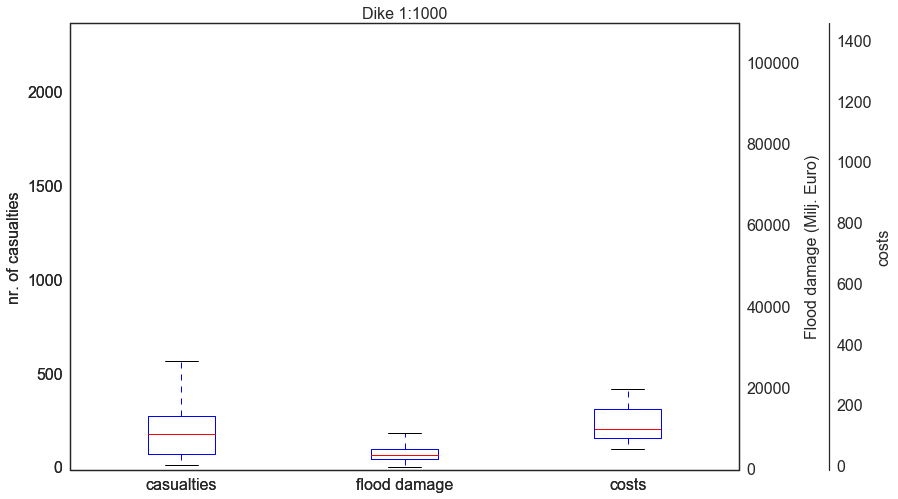

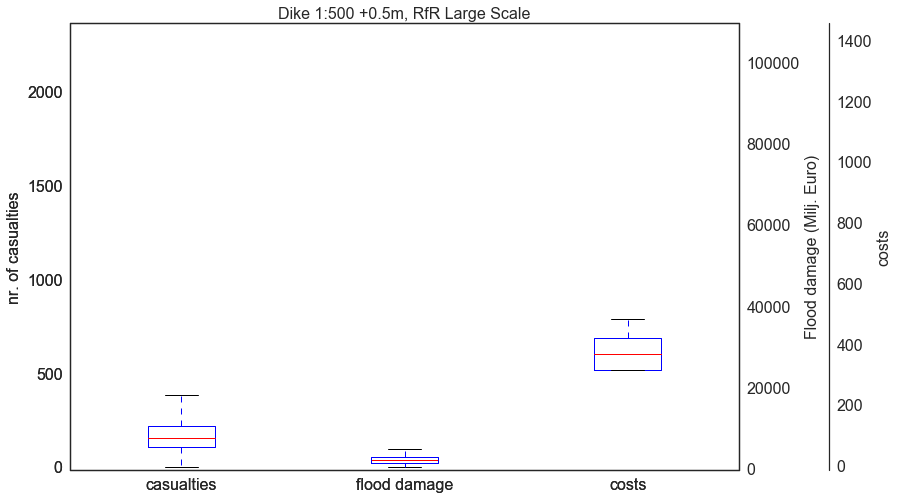

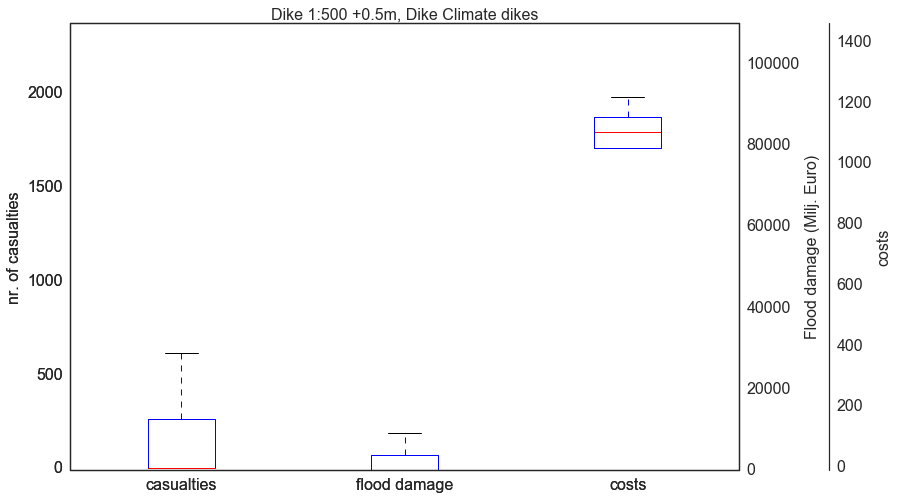

In [32]:
fn  = r'./data/third iteration 7 policies  5000 runs.tar.gz'
experiments, outcomes = load_results(fn)

policies = ['Dike 1:1000','Dike 1:500 +0.5m, RfR Large Scale','Dike 1:500 +0.5m, Dike Climate dikes']

logical = np.zeros(experiments.shape, dtype=np.bool)
for policy in policies:
    logical[experiments['policy']==policy] = True
logical[experiments['policy']=='no policy'] = True

max_casualties = np.max(outcomes['Number of casualties'][logical])
max_damages = np.max(outcomes['Flood damage (Milj. Euro)'][logical])
max_costs = np.max(outcomes['Costs'][logical])

    
with sns.axes_style('white'):
    for i, policy in enumerate(policies):
        logical = experiments['policy']==policy

        # policy
        casualties = outcomes['Number of casualties'][logical]
        ax_casualties = host = host_subplot(111, axes_class=AA.Axes)
        ax_casualties.boxplot([casualties,[],[]])
        ax_casualties.set_ylabel('nr. of casualties')

        damages = outcomes['Flood damage (Milj. Euro)'][logical]
        ax_damage = ax_casualties.twinx()
        ax_damage.boxplot([[],damages,[]])
        ax_damage.set_ylabel('Flood damage (Milj. Euro)')

        costs = outcomes['Costs'][logical]
        ax_costs = ax_casualties.twinx()
        offset = 90

        new_fixed_axis = ax_costs.get_grid_helper().new_fixed_axis
        ax_costs.axis["right"] = new_fixed_axis(loc="right",
                                            axes=ax_costs,
                                            offset=(offset, 0))

        ax_costs.axis["right"].toggle(all=True)
        ax_costs.boxplot([[],[], costs])
        ax_costs.set_ylabel('costs')

        ax_casualties.set_xticklabels(['casualties', 'flood damage','costs'])
        ax_casualties.set_ylim(ymin=0)
        ax_casualties.set_title(policy)

        # the xaxis for must be set to the same limits
        ax_casualties.set_ylim(ymin=-10, ymax=1.2*max_casualties)

        ax_damage.set_ylim(ymin=-10, ymax=1.2*max_damages)

        ax_costs.set_ylim(ymin=-10, ymax=1.2*max_costs)
        plt.subplots_adjust(wspace = .75)
    
        fig = plt.gcf()
        change_fontsize(fig, 16)
        save_fig(fig, './figs/','7{}'.format(chr(i + ord('a'))))


        plt.show()



In [33]:
print set(experiments['policy'])

set(['Dike 1:500 +0.5m, Dike Climate dikes', 'Dike 1:500 +0.5m, RfR Large Scale', 'Dike 1:500 +0.5m, RfR Medium Scale', 'Dike 1:500 +0.5m', 'Dike 1:500 +0.5m, Alarm Early', 'no policy', 'Dike 1:1000'])


In [34]:
def get_results_for_policies(results, policies):
    
    experiments, outcomes = results
    
    logical = np.zeros((experiments.shape[0],), np.bool)
    
    for policy in policies:
        logical[experiments['policy']==policy] = True
    
    temp_exp = experiments[logical]
    temp_out = {key: value[logical] for key, value in outcomes.items()}

    
    temp_exp['policy'] = 'not relevant'
    logical = temp_exp['climate scenarios']<11
    temp_exp['climate scenarios'][logical] = 0
    
    logical = (temp_exp['climate scenarios']<21) & (temp_exp['climate scenarios']>10)
    temp_exp['climate scenarios'][logical] = 1
    
    logical  = temp_exp['climate scenarios']>20
    temp_exp['climate scenarios'][logical] = 2
    
    return temp_exp, temp_out

fn  = r'./data/third iteration 7 policies  5000 runs.tar.gz'
results = load_results(fn)
policies = ['Dike 1:500 +0.5m, Dike Climate dikes',  
            'Dike 1:1000',
            'Dike 1:500 +0.5m, RfR Large Scale']
relevant_results = get_results_for_policies(results, policies)   

[INFO] results loaded succesfully from ./data/third iteration 7 policies  5000 runs.tar.gz


## Third iteration prim

based on the results above, we have selected 3 policies

 * Dike 1:500 +0.5m, Dike Climate dikes
 * ike 1:500 +0.5m, Alarm Early'
 * Dike 1:1000
 
For some reason the results of dike 1:500 and room for the river are off, this needs to be investigated in the next version of this analysis. 

### scenario discovery for casualties

We can now perform scenario discovery. 

$
f(x) = 
    \begin{cases}
        1 & \text{if } x > 300 \\
        0 & \text{otherwise}
    \end{cases}
$$
$

where $x$ is the number of casualties



In [35]:
from ema_workbench.analysis import prim
from ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

def classify(data):
    ooi = 'Number of casualties'
    outcome = data[ooi]
    classes = np.zeros(outcome.shape[0])
    classes[outcome>250] = 1
    return classes

prim_obj = prim.setup_prim(relevant_results, classify, threshold=0.4, peel_alpha=0.05)
box_1 = prim_obj.find_box()

[INFO] 15000 points remaining, containing 3773 cases of interest
[INFO] mean: 0.607007575758, mass: 0.0704, coverage: 0.169891333157, density: 0.607007575758 restricted_dimensions: 6.0


In [36]:
import mpld3
box_1.show_tradeoff()
mpld3.display()


In [37]:
box_1.inspect(5)

coverage    0.411344
density     0.535542
mass        0.193200
mean        0.535542
res dim     2.000000
Name: 5, dtype: float64

                                                                box 5  \
                                                                  min   
climate scenarios                                                   2   
land use scenarios  {urbanizationLargeSteady, urbanizationDeurbani...   

                                                                       \
                                                                  max   
climate scenarios                                                   2   
land use scenarios  {urbanizationLargeSteady, urbanizationDeurbani...   

                                  
                       qp values  
climate scenarios   3.559500e-81  
land use scenarios  8.225532e-37  



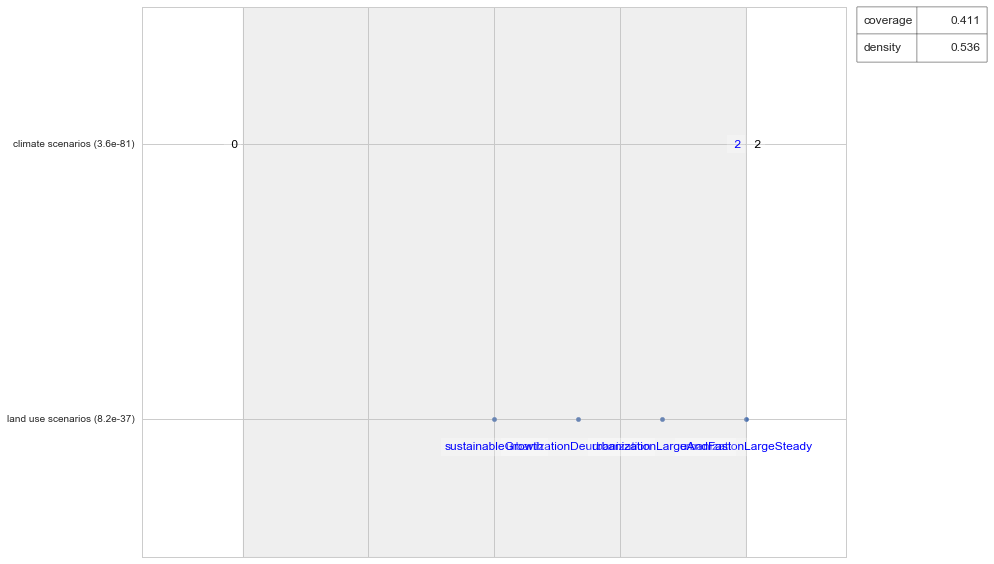

In [38]:
box_1.inspect(5, style='graph')
plt.show()

In [39]:
box_1.select(5)
box_2 = prim_obj.find_box()

[INFO] 12102 points remaining, containing 2221 cases of interest
[INFO] box does not meet threshold criteria, value is 0.383480825959, returning dump box


### Scenario discovery for damages

We can now perform scenario discovery. 

$
f(x) = 
    \begin{cases}
        1 & \text{if } x > 5000 \\
        0 & \text{otherwise}
    \end{cases}
$$
$

where $x$ is the amount of flood damage

In [40]:
from ema_workbench.analysis import prim
from ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

def classify(data):
    ooi = 'Flood damage (Milj. Euro)'
    outcome = data[ooi]
    classes = np.zeros(outcome.shape[0])
    classes[outcome>5000] = 1
    return classes


prim_obj = prim.setup_prim(relevant_results, classify, threshold=0.5, peel_alpha=0.01, mass_min=0.01)
box_1 = prim_obj.find_box()

[INFO] 15000 points remaining, containing 2291 cases of interest
[INFO] mean: 0.598984771574, mass: 0.0394, coverage: 0.15451767787, density: 0.598984771574 restricted_dimensions: 7.0


In [41]:
import mpld3
box_1.show_tradeoff()
mpld3.display()


In [42]:
box_1.inspect(10)

coverage    0.580533
density     0.483988
mass        0.183200
mean        0.483988
res dim     5.000000
Name: 10, dtype: float64

                                                               box 10  \
                                                                  min   
climate scenarios                                                   2   
land use scenarios  {urbanizationLargeSteady, urbanizationDeurbani...   
fragility dikes                                            -0.0959767   
ShipTbl1                                                    -0.096088   
collaboration                                                 1.00764   

                                                                       \
                                                                  max   
climate scenarios                                                   2   
land use scenarios  {urbanizationLargeSteady, urbanizationDeurbani...   
fragility dikes                                             0.099

It is quite evident that the combination of climate change (W+) and strong urbanization is the main driver for poor outcomes. A next step would be to make an adaptive policy where we strengthen dikes conditional on either a climate signal, or a land use signal, or both. Earlier work on the Rhine suggests that one of the best indicators for detecting climate change is the running average over 30 years of the number of days flows are below 12000 m^3/s. 

Using this, we can make an adaptive policy. For demostration purposes, we make two adaptive policies
 * 1:500, followed by 1:1000 in case of climate change signal
 * 1:500 with climate dikes, followed by dike strengthening to 1:1000 in case of climate change signal

## fourth iteration, adaptive policy

In [43]:
from ema_workbench.util import load_results

experiments, outcomes = load_results('./data/fourth iteration 5 policies  5000 runs.tar.gz')

for entry in set(experiments['policy']):
    logical = experiments['policy']==entry
    print entry, np.sum(logical)
    


[INFO] results loaded succesfully from ./data/fourth iteration 5 policies  5000 runs.tar.gz


Dike 1:500 +0.5m 5000
Dike 1:500 +0.5m, 1:1000 5000
no policy 5000
Dike 1:500 +0.5m, Dike Climate dikes, 1:1000 5000
Dike 1:1000 5000


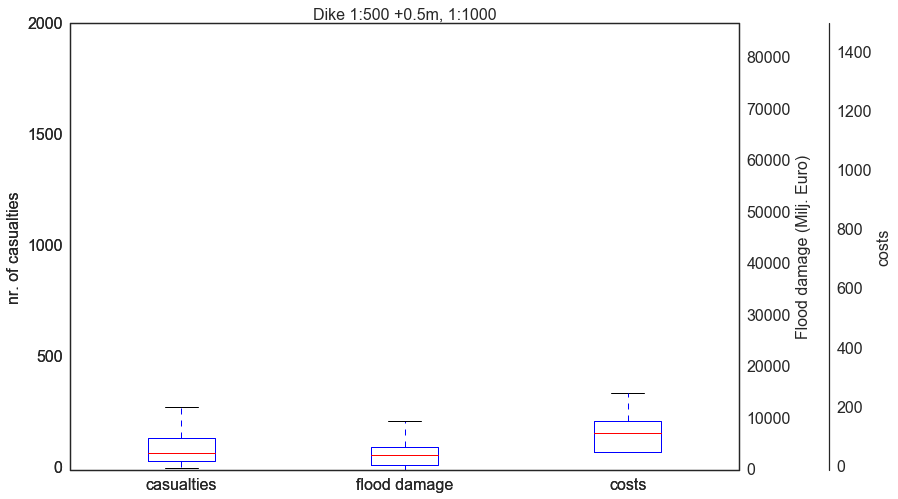

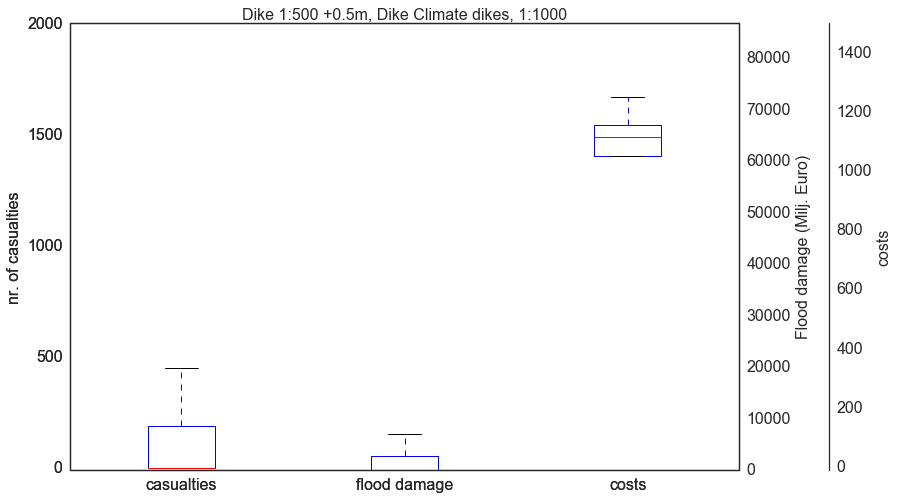

In [44]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

policies = ['Dike 1:500 +0.5m, 1:1000','Dike 1:500 +0.5m, Dike Climate dikes, 1:1000']

#determine maxima across all policies
costs = outcomes['Costs']
max_costs = np.max(costs)

casualties = outcomes['Number of casualties']
max_casualties = np.max(casualties)

damages = outcomes['Flood damage (Milj. Euro)']
max_damages = np.max(damages)

with sns.axes_style('white'):
    for i, policy in enumerate(policies):
        logical = experiments['policy']==policy
        temp_outcomes = {key:value[logical] for key, value in outcomes.items()}

        fig = plt.figure()

        # policy

        casualties2 = temp_outcomes['Number of casualties']
        ax_casualties2 = host = host_subplot(111, axes_class=AA.Axes)
        ax_casualties2.boxplot([casualties2,[],[]])
        ax_casualties2.set_ylabel('nr. of casualties')

        damages2 = temp_outcomes['Flood damage (Milj. Euro)']
        ax_damage2 = ax_casualties2.twinx()
        ax_damage2.boxplot([[],damages2,[]])
        ax_damage2.set_ylabel('Flood damage (Milj. Euro)')

        costs = temp_outcomes['Costs']
        ax_costs = ax_casualties2.twinx()
        offset = 90

        new_fixed_axis = ax_costs.get_grid_helper().new_fixed_axis
        ax_costs.axis["right"] = new_fixed_axis(loc="right",
                                            axes=ax_costs,
                                            offset=(offset, 0))

        ax_costs.axis["right"].toggle(all=True)
        ax_costs.boxplot([[],[], costs])
        ax_costs.set_ylabel('costs')

        ax_casualties2.set_xticklabels(['casualties', 'flood damage','costs'])
        ax_casualties2.set_ylim(ymin=0)
        ax_casualties2.set_title(policy)

        # the xaxis for must be set to the same limits
        ax_casualties2.set_ylim(ymin=-10, ymax=1.2*max_casualties)

        ax_damage2.set_ylim(ymin=-10, ymax=1.2*max_damages)

        ax_costs.set_ylim(ymin=-10, ymax=1.2*max_costs)
        plt.subplots_adjust(wspace = .75)

        change_fontsize(fig, 16)
        
        save_fig(fig, './figs/','8{}'.format(chr(i + ord('a'))))

        
        plt.show()




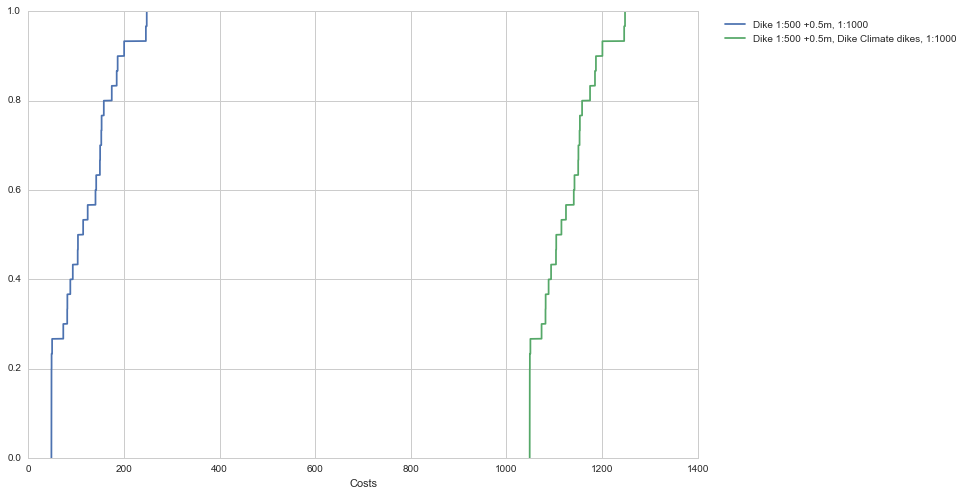

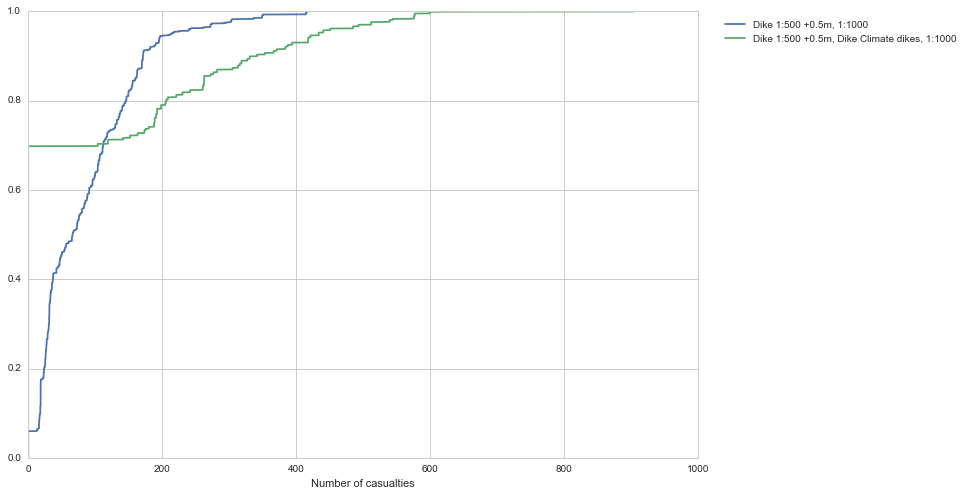

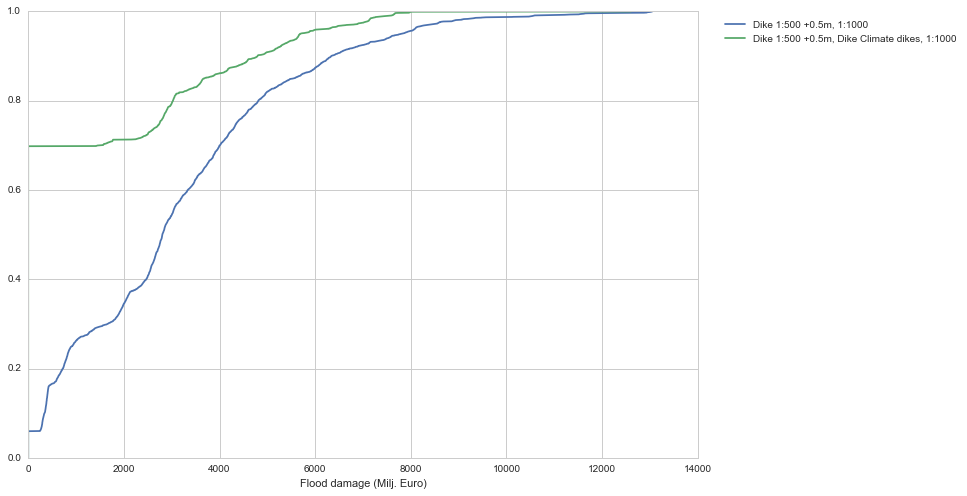

In [46]:
from ema_workbench.analysis.plotting_util import determine_kde

for ooi in outcomes.keys():

    fig = plt.figure()
    ax = fig.add_subplot(111)
    minima = np.min(outcomes[ooi])
    maxima = np.max(outcomes[ooi])
    
    
    for policy in policies:
        logical = experiments['policy']==policy
        temp_outcomes = {key:value[logical] for key, value in outcomes.items()}


        data = temp_outcomes[ooi]
        x = np.sort(data)
        y = np.arange(len(x))/float(len(x))
        
        ax.plot(x, y, label=policy)
        ax.set_xlabel(ooi)
    ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))
plt.show()
    
    
    

In [57]:
logical = experiments['policy']=='Dike 1:500 +0.5m, 1:1000'

data = []

for key, value in outcomes.items():
    value = value[logical]
    data.append((key, np.mean(value), np.std(value)))
    
data = pd.DataFrame(data, columns=['ooi', 'mean','std'])
data.to_clipboard()
data

,ooi,mean,std
0,Costs,118.140425,59.053486
1,Number of casualties,85.278782,75.219697
2,Flood damage (Milj. Euro),3109.739000,2401.193676
